# 📢 Penjelasan Isi File
---


Pada tahap ini, saya akan fokus melakukan Exploratory Data Analysis (EDA) dan Preprocessing terhadap data URL dari paper [LOOK BEFORE YOU LEAP](https://www.sciencedirect.com/science/article/pii/S0957417423016858)

# ✅ **Conclusion**

---


- Data URL **terdapat kategori Phishing dan Non-phishing**

- Data URL-nya mayoritas tidak memiliki http atau https ataupun www

- Data duplikat sebanyak 1295 telah dihapus, menyisakan satu set data unik untuk setiap data yang sebelumnya terduplikasi.

- Jumlah data dalam kategori Phishing dan Non-Phishing hampir seimbang, dengan perbedaan sekitar 1000 data dari total sekitar 20.000 data dalam setiap kategori.

- URL terpendek dan terpanjang ditemukan dalam kategori Phishing.

- Sebagian besar URL Phishing menggunakan TLD 'com', menamai URL sesuai nama file seperti 'login.php' atau 'index.html', dan menggunakan layanan hosting gratis seperti 000webhostapp.

- 4 TLD teratas yang sering digunakan dalam URL Phishing adalah 'com', 'ru', 'net', dan 'org', sementara dalam URL Non-phishing, TLD yang sering digunakan adalah 'com', 'org', 'edu', dan 'edu'.

- 3 domain gratisan teratas yang sering digunakan dalam URL Phishing adalah 000webhostapp, blogspot, dan duckdns, sedangkan dalam URL Non-phishing, domain yang sering digunakan adalah ietf, angelfire, dan tripod.

- 2 subdomain teratas yang sering digunakan dalam URL Phishing adalah tidak ada subdomain dan 'www', sedangkan dalam URL Non-phishing, subdomain yang sering digunakan adalah 'www' dan 'tools'.

# 🎯 **Step 0: Import library**
---

In [1]:
!pip -q install imojify

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import json
import nltk
import re

from imojify import imojify
from collections import Counter
from wordcloud import WordCloud
from itertools import islice, chain
from nltk.tokenize import word_tokenize
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from sklearn.feature_extraction.text import CountVectorizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 19.4 MB/s eta 0:00:00


In [2]:
plt.style.use('seaborn-v0_8')

In [3]:
matplotlib.__version__

'3.7.1'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🎯 **Step 1: Load dataset**
---

In [5]:
path = '/content/drive/MyDrive/TUGAS AKHIR/Dataset/PESAN TEKS/DATASET_NON PHISHING.xlsx'

df_nonphishing = pd.read_excel(path)

df_nonphishing.head()

,Data
0,🔔 HARI TERAKHIR UNTUK DAPATKAN PROMO JOB CONNE...
1,🚀 EXCLUSIVE PROMO JOB CONNECTOR ON CAMPUS UP T...
2,🔔 3 HARI LAGI PROMO BERAKHIR UNTUK PROGRAM JOB...
3,🔔 HARI TERAKHIR PROMO EARLY BIRD INTAKE APRIL-...
4,🔔 3 HARI LAGI PROMO EARLY BIRD INTAKE APRIL-JU...


In [6]:
df_nonphishing['Category'] = 'non-phishing'

df_nonphishing.head()

,Data,Category
0,🔔 HARI TERAKHIR UNTUK DAPATKAN PROMO JOB CONNE...,non-phishing
1,🚀 EXCLUSIVE PROMO JOB CONNECTOR ON CAMPUS UP T...,non-phishing
2,🔔 3 HARI LAGI PROMO BERAKHIR UNTUK PROGRAM JOB...,non-phishing
3,🔔 HARI TERAKHIR PROMO EARLY BIRD INTAKE APRIL-...,non-phishing
4,🔔 3 HARI LAGI PROMO EARLY BIRD INTAKE APRIL-JU...,non-phishing


# 🎯 **Step 2: Check data info**
---

In [7]:
df_nonphishing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959 entries, 0 to 958
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Data      959 non-null    object
 1   Category  959 non-null    object
dtypes: object(2)
memory usage: 15.1+ KB


🚧 Berdasarkan informasi di atas dapat disimpulkan datasetnya tidak terdapat null values


# 🎯 **Step 3: Check duplicate data**
---

In [9]:
df_nonphishing.duplicated().sum()

4

In [10]:
duplicate_rows = df_nonphishing[df_nonphishing.duplicated()]

duplicate_rows.head()

,Data,Category
315,"Selamat siang, kak\nSaya ingin bertanya kenapa...",non-phishing
849,Oke deh coba dulu ae wes,non-phishing
933,Eh cher seingetmu gcloud itu dapet free tier b...,non-phishing
957,"antara kamu masukin di headers, atau ilangin v...",non-phishing


In [11]:
duplicate_counts = duplicate_rows.value_counts()

duplicate_counts

Data                                                                                                                                                                                                                                                                                                  Category    
Eh cher seingetmu gcloud itu dapet free tier berapa ?                                                                                                                                                                                                                                                 non-phishing    1
Oke deh coba dulu ae wes                                                                                                                                                                                                                                                                              non-phishing    1
Selamat siang, kak\nSaya ingin bertanya kenapa ID saya namanya yayang

🚧 Berdasarkan informasi di atas terdapat 4 data yang terduplikat sehingga harus dihapus untuk menghindari model belajar lebih dari 1 pada data yang sama karena model akan lebih mengingat data tersebut.

## ✨ 3.2 - Remove duplicate data & keep 1

In [12]:
df_nonphishing.drop_duplicates(keep='first', inplace=True)

In [13]:
df_nonphishing.duplicated().sum()

0

🚧 Berdasarkan informasi di atas tidak terdapat data terduplikasi

# 🎯 **Step 4: Check URL length**

---

In [14]:
df_nonphishing['message_length'] = df_nonphishing['Data'].apply(len)

## ✨ 4.1 - Bar plot

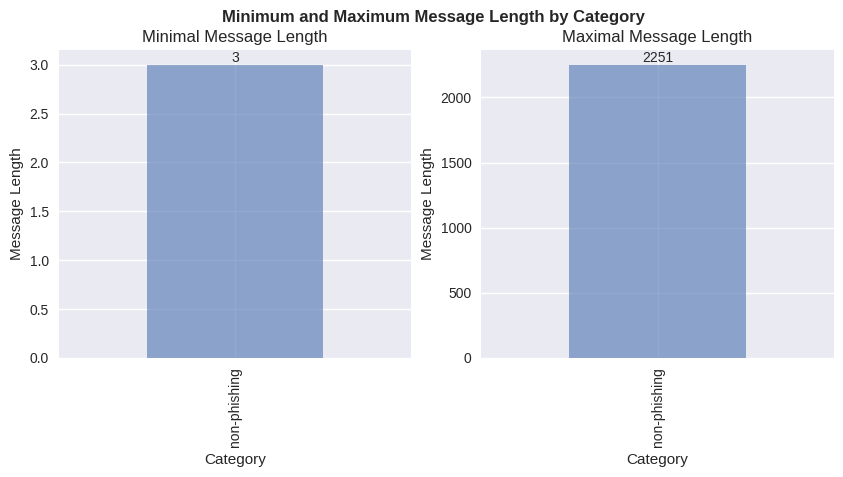

In [15]:
def plot_text_length(df, column, label):

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    fig.suptitle('Minimum and Maximum Message Length by Category', fontweight="bold")

    df.groupby(label)[column].min().plot(kind='bar', ax=axes[0], alpha=0.6)
    axes[0].set_title('Minimal Message Length')
    axes[0].set_ylabel('Message Length')
    for p in axes[0].containers:
        axes[0].bar_label(p,)

    df.groupby(label)[column].max().plot(kind='bar', ax=axes[1], alpha=0.6)
    axes[1].set_title('Maximal Message Length')
    axes[1].set_ylabel('Message Length')
    for p in axes[1].containers:
        axes[1].bar_label(p,)

    plt.show()

plot_text_length(df_nonphishing, 'message_length', 'Category')

## ✨ 4.2 - Box plot

<ipython-input-18-feff8ad1601e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Category', y='message_length', data=df_nonphishing, palette='rocket', whis=3.0)


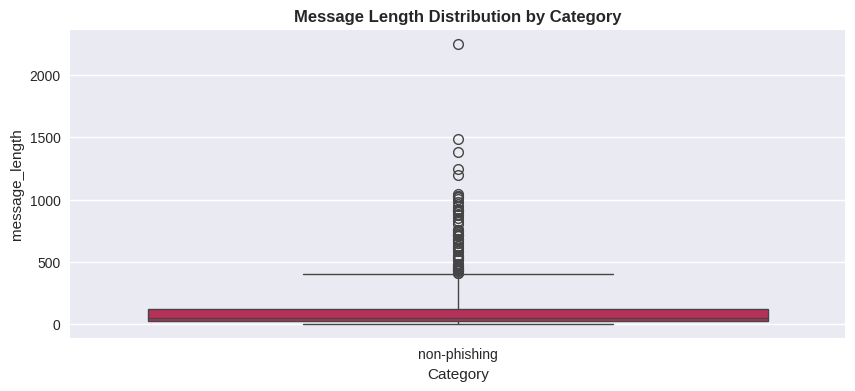

In [18]:
plt.figure(figsize=(10, 4))

ax = sns.boxplot(x='Category', y='message_length', data=df_nonphishing, palette='rocket', whis=3.0)

plt.title('Message Length Distribution by Category', fontweight="bold")

plt.show()

In [19]:
df_nonphishing.groupby('Category')['message_length'].mean()

Category
non-phishing    123.786387
Name: message_length, dtype: float64

🚧 Berdasarkan grafik di atas dapat dilihat bahwasanya rata-rata panjang pesannya sekitar 124.

# 🎯 **Step 5: Check the words unigram, bigram, trigrams that often appear**

---


🔎 Pada tahap ini saya menggunakan perpustakaan `CountVectorizer` dari Sklearn untuk menghitung frekuensi kemunculan kata dari unigram, bigram, dan trigram. Lalu saya filter untuk menampilkan 10 kata teratas yang paling banyak kemunculannya

🔎 Tujuan: tren popularitas dan pola perilaku dalam penggunaan Pesan Phishing.

In [20]:

def get_top_ngrams(corpus, ngram_range, stop_words=None, n=None):

    vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range)

    X = vectorizer.fit_transform(corpus)

    words = vectorizer.get_feature_names_out()

    freqs = X.sum(axis=0).A1

    df = pd.DataFrame({'Data': words, 'Frequency': freqs})

    df = df.sort_values(by='Frequency', ascending=False).head(n).reset_index(drop=True)

    return df

def plot_to_graph(plot_data):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # axes[1, 1].axis('off')

    for i, plot_info in enumerate(plot_data):

        ax = axes[i]

        sns.barplot(data=plot_info['data'], x='Frequency', y='Data', palette='rocket', ax=ax)

        for p in ax.patches:
            ax.annotate(f'{int(p.get_width())}', (p.get_x() + p.get_width(), p.get_y() + 0.5), ha='right', va='center', color='white')

        ax.set_title(plot_info['title'], fontweight="bold")

    plt.tight_layout()

    plt.show()

In [21]:
df_non = df_nonphishing[df_nonphishing['Category'] == 'non-phishing']

## ✨ 5.1 - Unigram

In [22]:
stop_words = None

n = 10

unigram_non_phishing = get_top_ngrams(df_nonphishing['Data'], (1, 1), stop_words, n)

unigram_non_phishing.head()


,Data,Frequency
0,kak,343
1,di,302
2,yang,257
3,untuk,244
4,ini,188


<ipython-input-20-9436c91abedd>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_info['data'], x='Frequency', y='Data', palette='rocket', ax=ax)


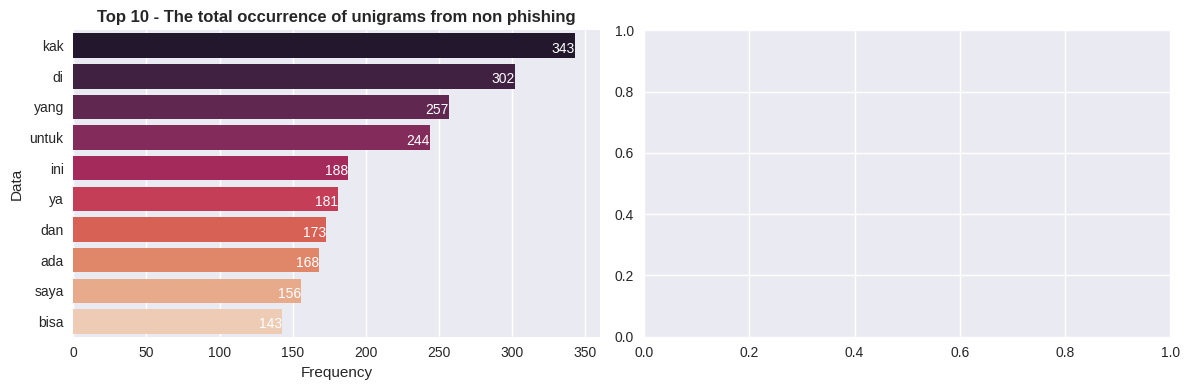

In [23]:
plot_data = [

    {'data': unigram_non_phishing, 'title': 'Top 10 - The total occurrence of unigrams from non phishing'},
]

plot_to_graph(plot_data)

🚧 Berdasarkan grafik di atas dapat dilihat bahwasanya unigram 'anda' dan 'untuk' menempati posisi 3 teratas.

## ✨ 5.2 - Bigram

In [24]:
stop_words = None

n = 10

bigram_non_phishing = get_top_ngrams(df_nonphishing['Data'], (2, 2), stop_words, n)

bigram_non_phishing.head()


,Data,Frequency
0,ya kak,75
1,terima kasih,51
2,muhammad firdho,32
3,firdho kustiawan,29
4,hari ini,29


<ipython-input-20-9436c91abedd>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_info['data'], x='Frequency', y='Data', palette='rocket', ax=ax)


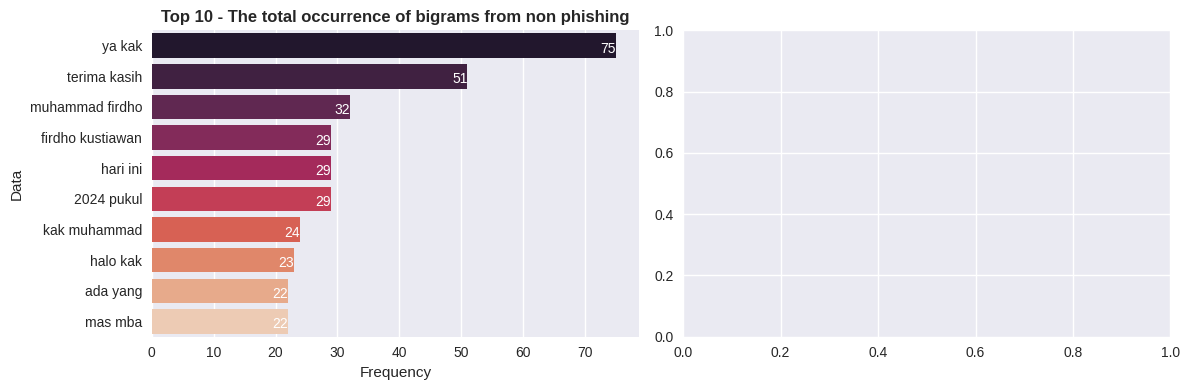

In [25]:
plot_data = [

    {'data': bigram_non_phishing, 'title': 'Top 10 - The total occurrence of bigrams from non phishing'},
]

plot_to_graph(plot_data)

## ✨ 5.3 - Trigram

In [28]:
stop_words = None

n = 10

trigram_non_phishing = get_top_ngrams(df_nonphishing['Data'], (3, 3), stop_words, n)

trigram_non_phishing.head()


,Data,Frequency
0,muhammad firdho kustiawan,28
1,kak muhammad firdho,24
2,pukul 23 59,21
3,23 59 wib,21
4,maret 2024 pukul,20


<ipython-input-20-9436c91abedd>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_info['data'], x='Frequency', y='Data', palette='rocket', ax=ax)


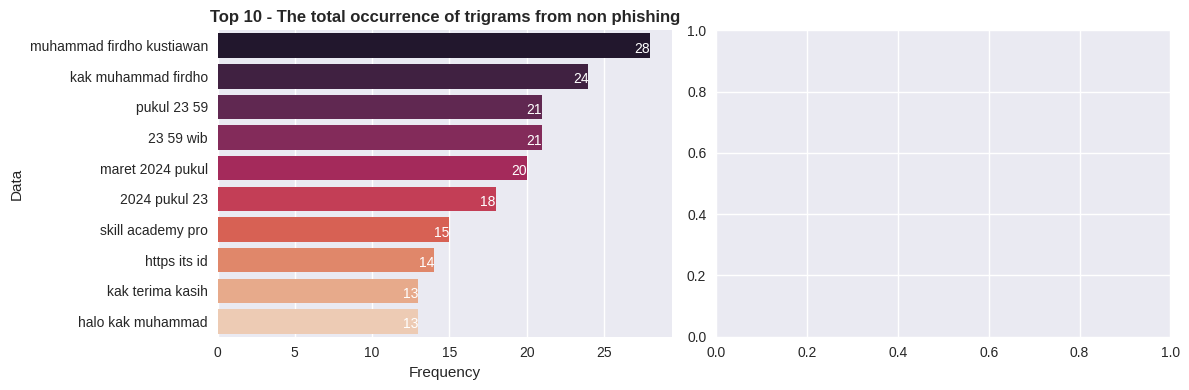

In [29]:
plot_data = [

    {'data': trigram_non_phishing, 'title': 'Top 10 - The total occurrence of trigrams from non phishing'},
]

plot_to_graph(plot_data)

# 🎯 **Step 6: Check the wordcloud**

---


🔎 At this stage I display a wordcloud from each class of course with additions from all classes

In [30]:
def create_wordcloud(palette, data_target):

    sentiment_data = ' '.join(data_target)

    wordcloud = WordCloud(background_color='black', colormap=palette, collocations=False).generate(sentiment_data)

    return wordcloud

def plot_wordcloud(plot_data):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

    for i, plot_info in enumerate(plot_data):

        col = i % 2
        ax = axes[col]

        ax.imshow(plot_info['data'], interpolation='bilinear')
        ax.axis("off")
        ax.set_title(plot_info['title'], fontsize=28)

    plt.tight_layout()
    plt.show()

In [31]:
wordcloud_non_phishing = create_wordcloud('Greens', df_nonphishing['Data'])

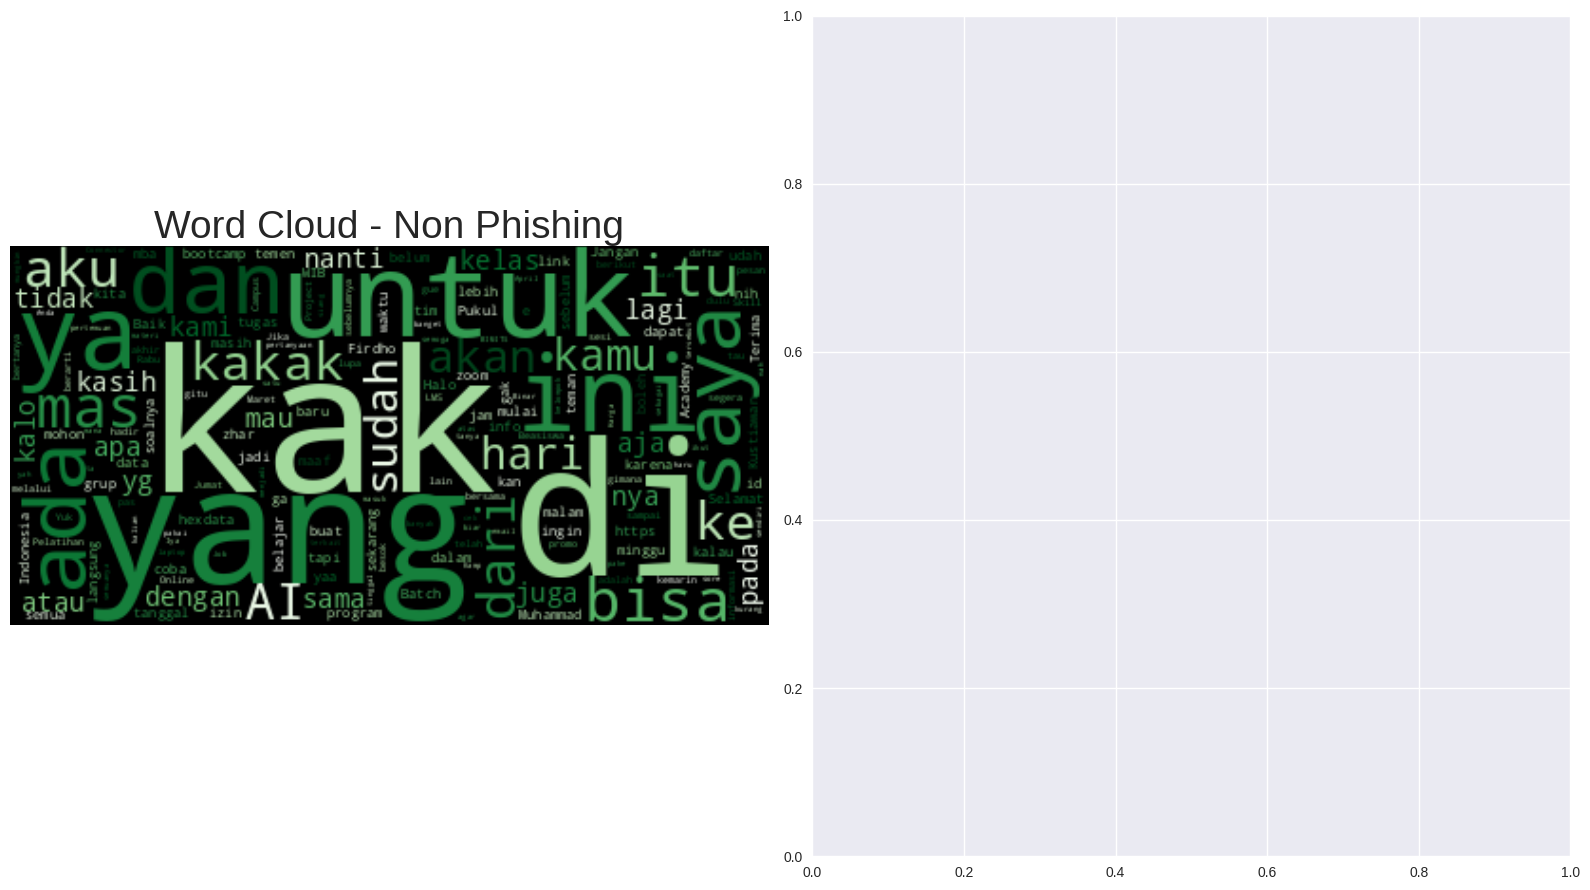

In [32]:
# Contoh penggunaan
plot_data = [

    {'data': wordcloud_non_phishing , 'title': 'Word Cloud - Non Phishing'},
]

plot_wordcloud(plot_data)

# 🎯 **Step 7: Save data after preprocessing**

---


In [33]:
df_nonphishing.head()

,Data,Category,message_length
0,🔔 HARI TERAKHIR UNTUK DAPATKAN PROMO JOB CONNE...,non-phishing,477
1,🚀 EXCLUSIVE PROMO JOB CONNECTOR ON CAMPUS UP T...,non-phishing,628
2,🔔 3 HARI LAGI PROMO BERAKHIR UNTUK PROGRAM JOB...,non-phishing,464
3,🔔 HARI TERAKHIR PROMO EARLY BIRD INTAKE APRIL-...,non-phishing,433
4,🔔 3 HARI LAGI PROMO EARLY BIRD INTAKE APRIL-JU...,non-phishing,425


In [34]:
df_nonphishing.drop(columns=['message_length'], inplace=True)

df_nonphishing.head()

,Data,Category
0,🔔 HARI TERAKHIR UNTUK DAPATKAN PROMO JOB CONNE...,non-phishing
1,🚀 EXCLUSIVE PROMO JOB CONNECTOR ON CAMPUS UP T...,non-phishing
2,🔔 3 HARI LAGI PROMO BERAKHIR UNTUK PROGRAM JOB...,non-phishing
3,🔔 HARI TERAKHIR PROMO EARLY BIRD INTAKE APRIL-...,non-phishing
4,🔔 3 HARI LAGI PROMO EARLY BIRD INTAKE APRIL-JU...,non-phishing


# 🎯 **Step 8: Save Dataset**

---


In [35]:
df_nonphishing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 955 entries, 0 to 958
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Data      955 non-null    object
 1   Category  955 non-null    object
dtypes: object(2)
memory usage: 22.4+ KB


In [36]:
df_nonphishing.to_csv('/content/drive/MyDrive/TUGAS AKHIR/Dataset/PESAN TEKS/bb_pesan-teks-nonphishing.csv', index=False)